In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import transforms
import pywt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
import prophet

Importing plotly failed. Interactive plots will not work.


In [3]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='data/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

In [4]:
data = load_subjects()

In [5]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029207,109


In [6]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [7]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
2928,37.66,1,107.487925,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1.000000,0.000000,0.000000,0.000000,101
2929,37.67,1,107.487925,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1.000000,0.000000,0.000000,0.000000,101
2930,37.68,1,107.487925,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1.000000,0.000000,0.000000,0.000000,101
2931,37.69,1,107.487925,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1.000000,0.000000,0.000000,0.000000,101
2932,37.70,1,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872015,95.06,24,162.000000,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109
2872016,95.07,24,162.000000,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,0.003629,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109
2872017,95.08,24,162.000000,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109
2872018,95.09,24,162.000000,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109


## Определение периода

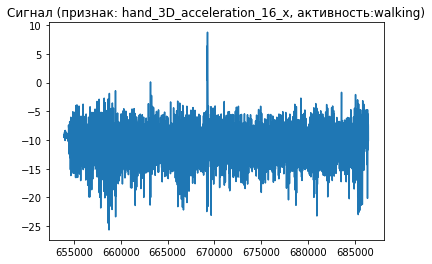

C:\Users\ivan\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


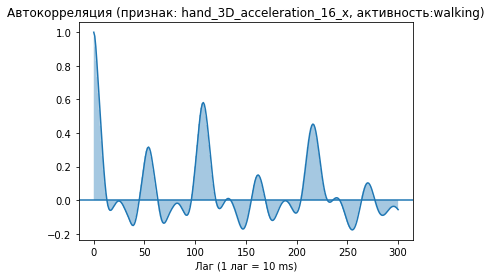

Период: 540 ms


In [118]:
idx = 102
activity = 4
name_activity = load_activity_map()[activity]
feature = 'hand_3D_acceleration_16_x'
ts = data.loc[(data['id']==idx) & (data['activity_id']==activity)][feature]
plt.plot(ts)
plt.title('Сигнал (признак: {}, активность:{})'.format(feature,name_activity))
plt.show()

lags = 300
acf_arr = acf(x=ts, nlags=lags)
plt.plot(acf_arr)
plt.title('Автокорреляция (признак: {}, активность:{})'.format(feature,name_activity))
plt.xlabel('Лаг (1 лаг = 10 ms)')
plt.axhline(y=0, linestyle='-')
plt.fill_between(np.arange(lags+1),acf_arr, step="pre", alpha=0.4)
plt.show()

period = find_peaks(acf_arr,height=0.1,prominence=0.1)[0][0]
print('Период: {}0 ms'.format(period))

In [10]:
#Активности
activities = load_activity_map()
activitie_idxs = list(data['activity_id'].unique())
activitie_names = [activities[i] for i in activitie_idxs]

#Сигналы
signals = list(data.columns)[2:-1]

In [34]:
lags = 300
idx = 102
periods = np.zeros((len(signals),len(activitie_idxs)))
for i, sig in tqdm(enumerate(signals)):
    for j, act in enumerate(activitie_idxs):
        ts = data.loc[(data['id']==idx) & (data['activity_id']==act)][sig]
        acf_arr = acf(x=ts, nlags=lags)
        try:
            period = find_peaks(acf_arr,height=0.1,prominence=0.05)[0][0]
        except:
            period = 0
        periods[i,j] = period

In [48]:
df_periods = pd.DataFrame(periods,index=signals,columns=activitie_names).astype('int')*10
df_periods

,lying,sitting,standing,ironing,vacuum_cleaning,ascending_stairs,descending_stairs,walking,Nordic_walking,cycling,running,rope_jumping
heart_rate,0,0,0,0,0,0,0,0,0,0,0,0
hand_temperature,0,0,0,0,0,0,0,0,0,0,0,0
hand_3D_acceleration_16_x,0,0,2480,0,0,580,480,540,540,90,760,410
hand_3D_acceleration_16_y,890,0,410,0,0,1120,590,1080,560,70,380,410
hand_3D_acceleration_16_z,0,0,880,0,0,1150,480,1080,550,60,760,840
hand_3D_acceleration_6_x,0,0,1230,0,0,580,480,540,540,90,760,410
hand_3D_acceleration_6_y,890,0,410,0,0,1120,580,1080,560,70,380,410
hand_3D_acceleration_6_z,0,0,870,0,0,1150,480,1080,550,70,760,840
hand_3D_gyroscope_x,1390,470,1360,0,0,1140,0,1080,1100,0,760,840
hand_3D_gyroscope_y,860,0,0,0,0,1160,990,540,1110,0,760,840


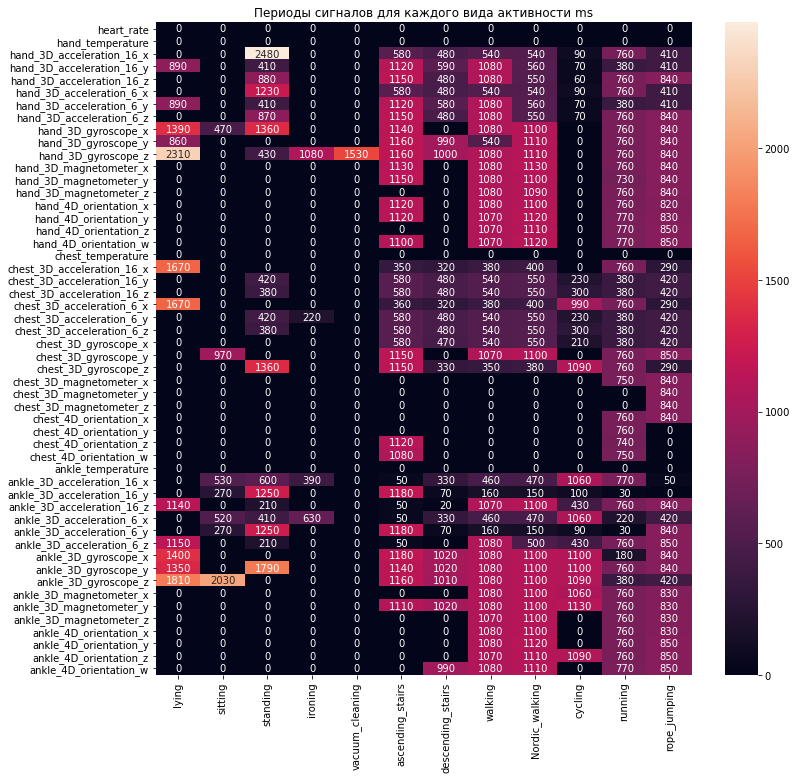

In [49]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df_periods, annot=True,fmt="d",ax=ax)
plt.title('Периоды сигналов для каждого вида активности ms')
plt.show()

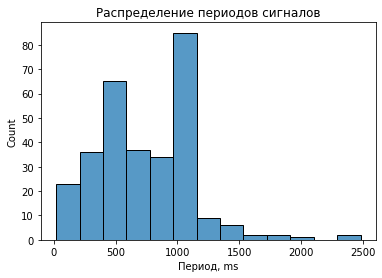

In [57]:
periods_f = df_periods.values.flatten()
periods_f = [i for i in periods_f if i!=0]
sns.histplot(periods_f)
plt.title('Распределение периодов сигналов')
plt.xlabel('Период, ms')
plt.show()

## Определение масштаба

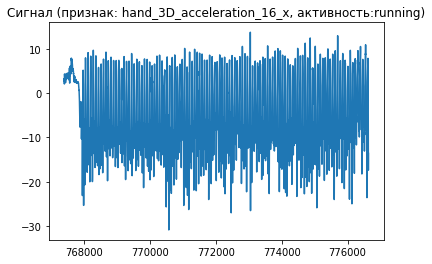

In [264]:
idx = 102
activity = 5
name_activity = load_activity_map()[activity]
feature = 'hand_3D_acceleration_16_x'
ts = data.loc[(data['id']==idx) & (data['activity_id']==activity)][feature]
plt.plot(ts)
plt.title('Сигнал (признак: {}, активность:{})'.format(feature,name_activity))
plt.show()

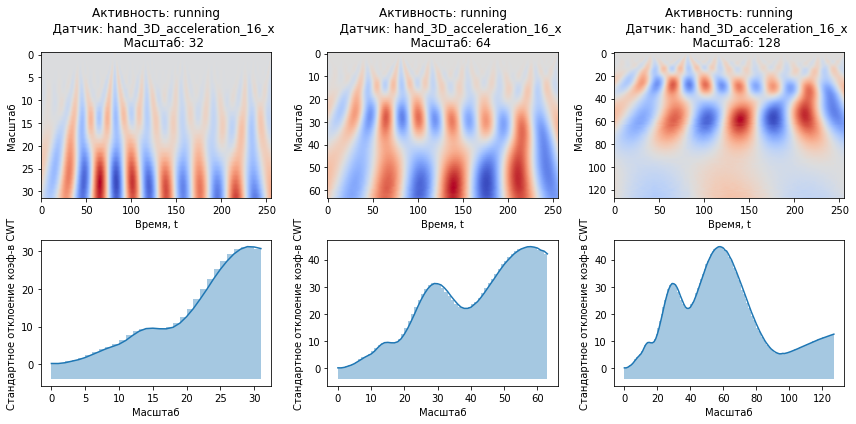

In [267]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    
for ax, scale in zip(axs.flat[:3], [32,64,128]):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,scale+1)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = 'morl')
    # create scalogram
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    name = """Активность: running
    Датчик: hand_3D_acceleration_16_x
    Масштаб: {}""".format(scale)
    ax.set_title(name)
    ax.set_ylabel('Масштаб')
    ax.set_xlabel('Время, t')

for ax, scale in zip(axs.flat[3:], [32,64,128]):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,scale+1)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = 'morl')
    # create scalogram
    #sns.histplot(coeffs.flatten(),ax=ax)
    std = np.std(coeffs,axis=1)
    ax.plot(std)#,transform= rot + base)
    ax.fill_between(np.arange(len(std)),np.ones(len(std))-5,std, step="pre", alpha=0.4)
    ax.set_ylabel('Стандартное отклоение коэф-в CWT')
    ax.set_xlabel('Масштаб')

plt.tight_layout()
plt.show()

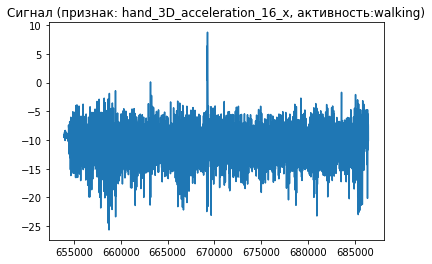

In [18]:
idx = 102
activity = 4
name_activity = load_activity_map()[activity]
feature = 'hand_3D_acceleration_16_x'
ts = data.loc[(data['id']==idx) & (data['activity_id']==activity)][feature]
plt.plot(ts)
plt.title('Сигнал (признак: {}, активность:{})'.format(feature,name_activity))
plt.show()

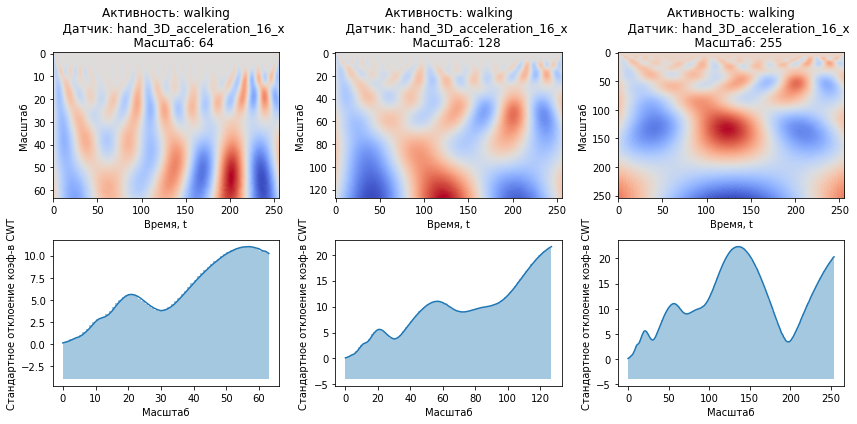

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    
for ax, scale in zip(axs.flat[:3], [64,128,255]):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,scale+1)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = 'morl')
    # create scalogram
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    name = """Активность: walking
    Датчик: hand_3D_acceleration_16_x
    Масштаб: {}""".format(scale)
    ax.set_title(name)
    ax.set_ylabel('Масштаб')
    ax.set_xlabel('Время, t')

for ax, scale in zip(axs.flat[3:], [64,128,255]):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,scale+1)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = 'morl')
    # create scalogram
    #sns.histplot(coeffs.flatten(),ax=ax)
    std = np.std(coeffs,axis=1)
    ax.plot(std)#,transform= rot + base)
    ax.fill_between(np.arange(len(std)),np.ones(len(std))-5,std, step="pre", alpha=0.4)
    ax.set_ylabel('Стандартное отклоение коэф-в CWT')
    ax.set_xlabel('Масштаб')

plt.tight_layout()
plt.show()

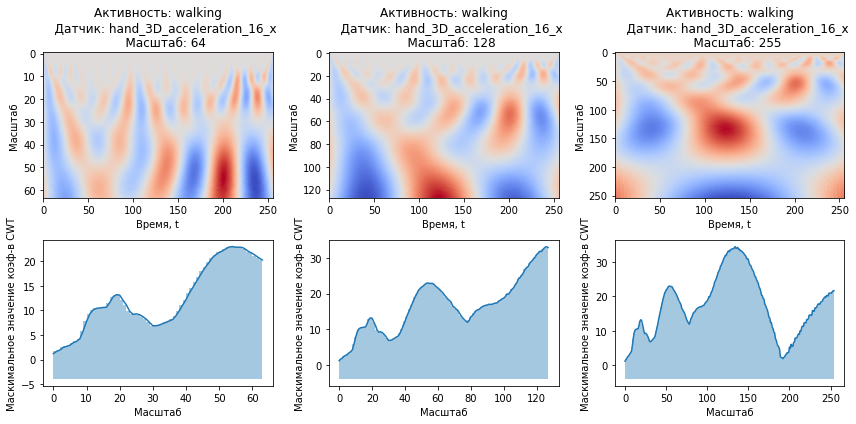

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    
for ax, scale in zip(axs.flat[:3], [64,128,255]):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,scale+1)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = 'morl')
    # create scalogram
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    name = """Активность: walking
    Датчик: hand_3D_acceleration_16_x
    Масштаб: {}""".format(scale)
    ax.set_title(name)
    ax.set_ylabel('Масштаб')
    ax.set_xlabel('Время, t')

for ax, scale in zip(axs.flat[3:], [64,128,255]):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,scale+1)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = 'morl')
    # create scalogram
    #sns.histplot(coeffs.flatten(),ax=ax)
    max_v = np.max(coeffs,axis=1)
    ax.plot(max_v)#,transform= rot + base)
    ax.fill_between(np.arange(len(max_v)),np.ones(len(max_v))-5,max_v, step="pre", alpha=0.4)
    ax.set_ylabel('Маскимальное значение коэф-в CWT')
    ax.set_xlabel('Масштаб')

plt.tight_layout()
plt.show()

In [23]:
#Активности
activities = load_activity_map()
activitie_idxs = list(data['activity_id'].unique())
activitie_names = [activities[i] for i in activitie_idxs]

#Сигналы
signals = list(data.columns)[2:-1]

In [24]:
idx = 102
start = 512
stop = 512+256
max_scales = 256

scales_arr = np.zeros((len(signals),len(activitie_idxs)))
for i, sig in tqdm(enumerate(signals)):
    for j, act in enumerate(activitie_idxs):
        ts = data.loc[(data['id']==idx) & (data['activity_id']==act)][sig]
        
        scales = np.arange(1,max_scales+1)
        coeffs, freqs = pywt.cwt(ts[start:stop], scales, wavelet = 'morl')
        
        std4csale = [np.max(coeffs[:i]) for i in range(1,256)]
        std4csale = np.argmax(std4csale)
        
        #plt.plot(std)
        #plt.fill_between(np.arange(len(std)),np.ones(len(std))-5,std, step="pre", alpha=0.4)
        #plt.show()
        #print(max_scale)
        scales_arr[i,j] = std4csale

0it [00:00, ?it/s]

In [25]:
df_scales = pd.DataFrame(scales_arr,index=signals,columns=activitie_names).astype('int')
df_scales = df_scales.applymap(lambda x: x if x!=254 else 0)
df_scales

,lying,sitting,standing,ironing,vacuum_cleaning,ascending_stairs,descending_stairs,walking,Nordic_walking,cycling,running,rope_jumping
heart_rate,0,0,0,0,0,0,0,0,0,0,0,0
hand_temperature,0,0,0,0,0,0,0,0,0,0,0,0
hand_3D_acceleration_16_x,138,196,138,0,0,141,54,134,123,143,59,99
hand_3D_acceleration_16_y,0,45,0,137,143,0,137,90,0,0,29,252
hand_3D_acceleration_16_z,0,167,252,212,0,139,46,80,53,0,115,73
hand_3D_acceleration_6_x,138,198,138,0,252,141,54,134,125,141,59,99
hand_3D_acceleration_6_y,0,45,0,137,140,58,137,89,252,252,29,0
hand_3D_acceleration_6_z,0,157,0,193,0,142,46,80,53,0,115,73
hand_3D_gyroscope_x,77,29,32,21,42,249,85,90,5,43,62,45
hand_3D_gyroscope_y,84,62,94,43,132,252,113,49,98,83,61,72


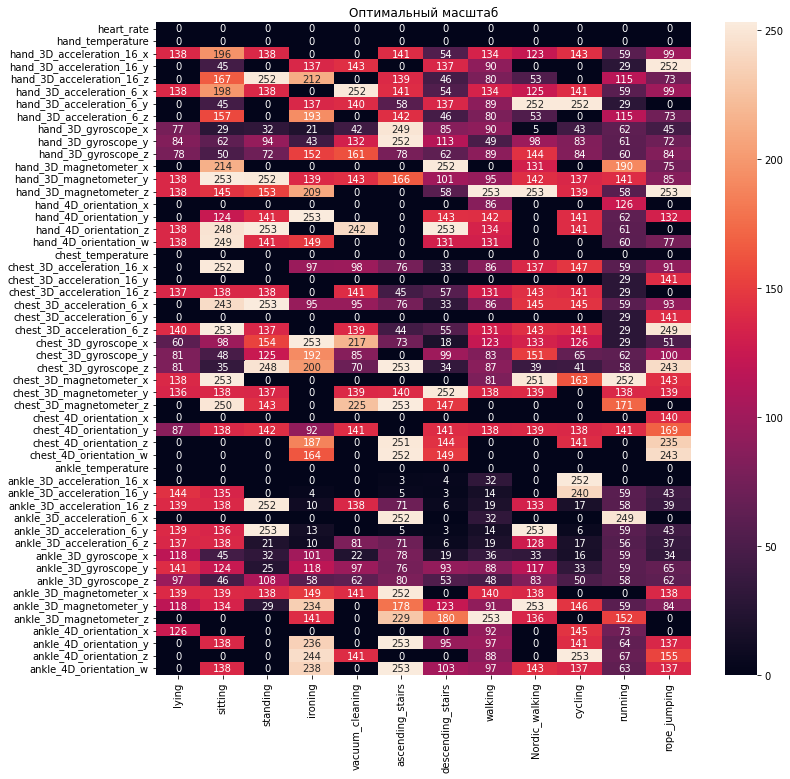

In [26]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df_scales, annot=True,fmt="d",ax=ax)
plt.title('Оптимальный масштаб')
plt.show()

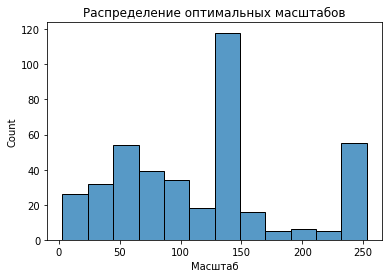

129.5


In [28]:
scales_f = df_scales.values.flatten()
scales_f = [i for i in scales_f if i!=0]
sns.histplot(scales_f)
plt.title('Распределение оптимальных масштабов')
plt.xlabel('Масштаб')
plt.show()

print(np.median(scales_f))

### Определение лучшего вейвлета

In [213]:
#Активности
activities = load_activity_map()
activitie_idxs = list(data['activity_id'].unique())
activitie_names = [activities[i] for i in activitie_idxs]

#Сигналы
signals = list(data.columns)[2:-1]

In [235]:
idx = 102
start = 512
stop = 512+256
wavelets = ['gaus1','gaus2','gaus3','gaus4','gaus5','gaus6','gaus7','gaus8','mexh','morl']

scales_arr = np.zeros((len(signals),len(activitie_idxs)))
for i, sig in tqdm(enumerate(signals)):
    for j, act in enumerate(activitie_idxs):
        ts = data.loc[(data['id']==idx) & (data['activity_id']==act)][sig]
        
        scales = np.arange(1,128)
        stds = []
        for var in wavelets:
            coeffs, freqs = pywt.cwt(ts[start:stop], scales, wavelet = var)
            stds.append(np.std(coeffs))
        stds = np.array(stds)
        best = np.argmax(stds)
            
        scales_arr[i,j] = best

0it [00:00, ?it/s]

In [240]:
df_scales = pd.DataFrame(scales_arr,index=signals,columns=activitie_names).astype('int')
df_scales = df_scales.applymap(lambda x: wavelets[x])
df_scales

,lying,sitting,standing,ironing,vacuum_cleaning,ascending_stairs,descending_stairs,walking,Nordic_walking,cycling,running,rope_jumping
heart_rate,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1
hand_temperature,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1
hand_3D_acceleration_16_x,gaus1,mexh,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,mexh
hand_3D_acceleration_16_y,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1
hand_3D_acceleration_16_z,gaus1,mexh,gaus1,mexh,gaus1,gaus1,mexh,gaus1,mexh,gaus1,mexh,gaus1
hand_3D_acceleration_6_x,gaus1,mexh,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,mexh
hand_3D_acceleration_6_y,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1,gaus1
hand_3D_acceleration_6_z,gaus1,mexh,gaus1,mexh,gaus1,gaus1,mexh,gaus1,mexh,gaus1,mexh,gaus1
hand_3D_gyroscope_x,morl,gaus3,mexh,mexh,mexh,gaus1,gaus8,gaus8,gaus8,gaus2,gaus8,gaus3
hand_3D_gyroscope_y,gaus8,gaus6,gaus1,gaus8,gaus2,gaus1,mexh,mexh,gaus1,gaus7,morl,morl


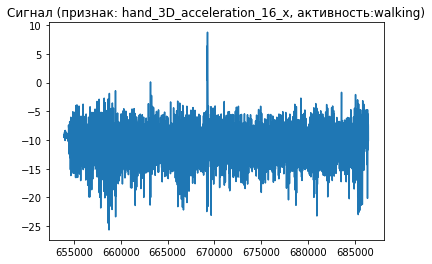

In [9]:
idx = 102
activity = 4
name_activity = load_activity_map()[activity]
feature = 'hand_3D_acceleration_16_x'
ts = data.loc[(data['id']==idx) & (data['activity_id']==activity)][feature]
plt.plot(ts)
plt.title('Сигнал (признак: {}, активность:{})'.format(feature,name_activity))
plt.show()

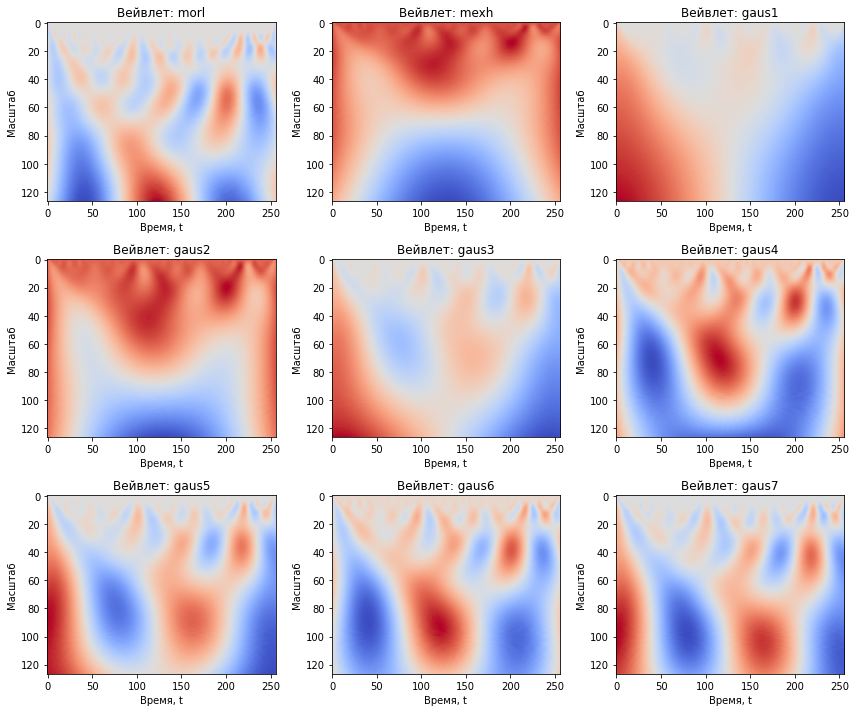

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
    
for ax, wave in zip(axs.flat, ['morl','mexh','gaus1', 'gaus2', 'gaus3', 'gaus4','gaus5', 'gaus6', 'gaus7']):
    # apply  PyWavelets continuous wavelet transfromation function
    scales = np.arange(1,128)
    coeffs, freqs = pywt.cwt(ts[512:512+256], scales, wavelet = wave)
    # create scalogram
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    name = """Вейвлет: {}""".format(wave)
    ax.set_title(name)
    ax.set_ylabel('Масштаб')
    ax.set_xlabel('Время, t')

plt.tight_layout()
plt.show()

In [244]:
np.unique(df_scales.values)

array(['gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7',
       'gaus8', 'mexh', 'morl'], dtype=object)

In [259]:
from collections import Counter
arr = df_scales.values.flatten()
counter = Counter(arr)
ser = pd.Series(counter.values(),index=counter.keys())
ser = ser.sort_values()
ser

gaus7      1
gaus5      3
gaus3      5
gaus4      6
gaus6      7
gaus2     16
morl      17
gaus8     50
mexh      86
gaus1    433
dtype: int64

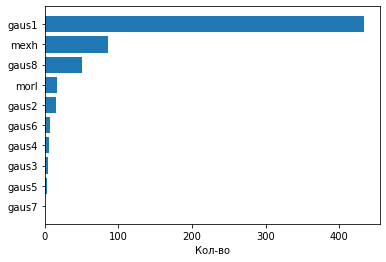

In [270]:
plt.barh(np.arange(len(ser)), ser.values)
plt.yticks(np.arange(len(ser)), labels=ser.index)
plt.xlabel('Кол-во')
plt.show()